# Lang compositional analysis

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [3]:
common_config.figure_journal_basic()

In [49]:
import pertpy as pt
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [5]:
adata = sc.read_h5ad("230114_hPCLS_perturbation.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 63581 × 17343
    obs: 'condition', 'modality', 'patient', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group', 'sample'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'QC_group_colors', 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'dendrogram_cell_type', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'modality_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'sample_colors', 'timepoint_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

In [7]:
adata.obs

,condition,modality,patient,treatment,identifier,n_counts,n_genes,percent_mito,QC_group,doublet_scores,size_factors,leiden_1,leiden_2,cell_type,cell_type_group,sample
muc31175_AAACCCAAGATCCCGC,Fibrotic Cocktail,PCLS,2,FC,muc31175,735.0,481,0.073469,low,0.051087,0.101679,0,7,T cells,T cells,FC_2
muc31175_AAACCCAAGTAAAGCT,Fibrotic Cocktail,PCLS,2,FC,muc31175,4782.0,2074,0.035968,low,0.020891,0.772610,4,2,ectopic EC,vascular EC,FC_2
muc31175_AAACCCACAAGTTGGG,Fibrotic Cocktail,PCLS,2,FC,muc31175,1304.0,773,0.007669,low,0.027234,0.188760,1,0,Mast cells,Mast cells,FC_2
muc31175_AAACCCACACCAAAGG,Fibrotic Cocktail,PCLS,2,FC,muc31175,1986.0,1118,0.043807,low,0.164641,0.300193,1,0,Mast cells,Mast cells,FC_2
muc31175_AAACCCACACCTCGTT,Fibrotic Cocktail,PCLS,2,FC,muc31175,2049.0,986,0.060517,low,0.138672,0.283763,21,33,B cells,B cells,FC_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
muc24279_TTTGATCGTTAGTCGT,Fibrotic Cocktail,PCLS,1,FC,muc24279,10589.0,3476,0.014166,medium,0.050000,1.779824,2,5,capillary EC,capillary EC,FC_1
muc24279_TTTGATCGTTCCCACT,Fibrotic Cocktail,PCLS,1,FC,muc24279,658.0,438,0.004559,medium,0.047490,0.107031,17,18,Fibroblasts,Fibroblasts,FC_1
muc24279_TTTGGAGCACGATAGG,Fibrotic Cocktail,PCLS,1,FC,muc24279,5930.0,2419,0.037605,medium,0.038509,0.972865,15,14,Pericytes,SMC/Pericytes,FC_1
muc24279_TTTGTTGCAAGACAAT,Fibrotic Cocktail,PCLS,1,FC,muc24279,2786.0,1487,0.045226,medium,0.042802,0.472818,19,20,Mast cells,Mast cells,FC_1


## scCODA

In [8]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_type",
    sample_identifier="sample",
    covariate_obs=["condition"],
)

In [9]:
sccoda_data

MuData object with n_obs × n_vars = 63589 × 17366
  var:	'n_cells'
  2 modalities
    rna:	63581 x 17343
      obs:	'condition', 'modality', 'patient', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group', 'sample'
      var:	'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'QC_group_colors', 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'dendrogram_cell_type', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'modality_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'sample_colors', 'timepoint_colors', 'treatment_colors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'unsouped_counts'
      obsp:	'connectivities', 'distances'
    coda:	8 x 23
      obs:	'condition', 'modality', 'patient', 'treatment'
      var:	'n_cells'

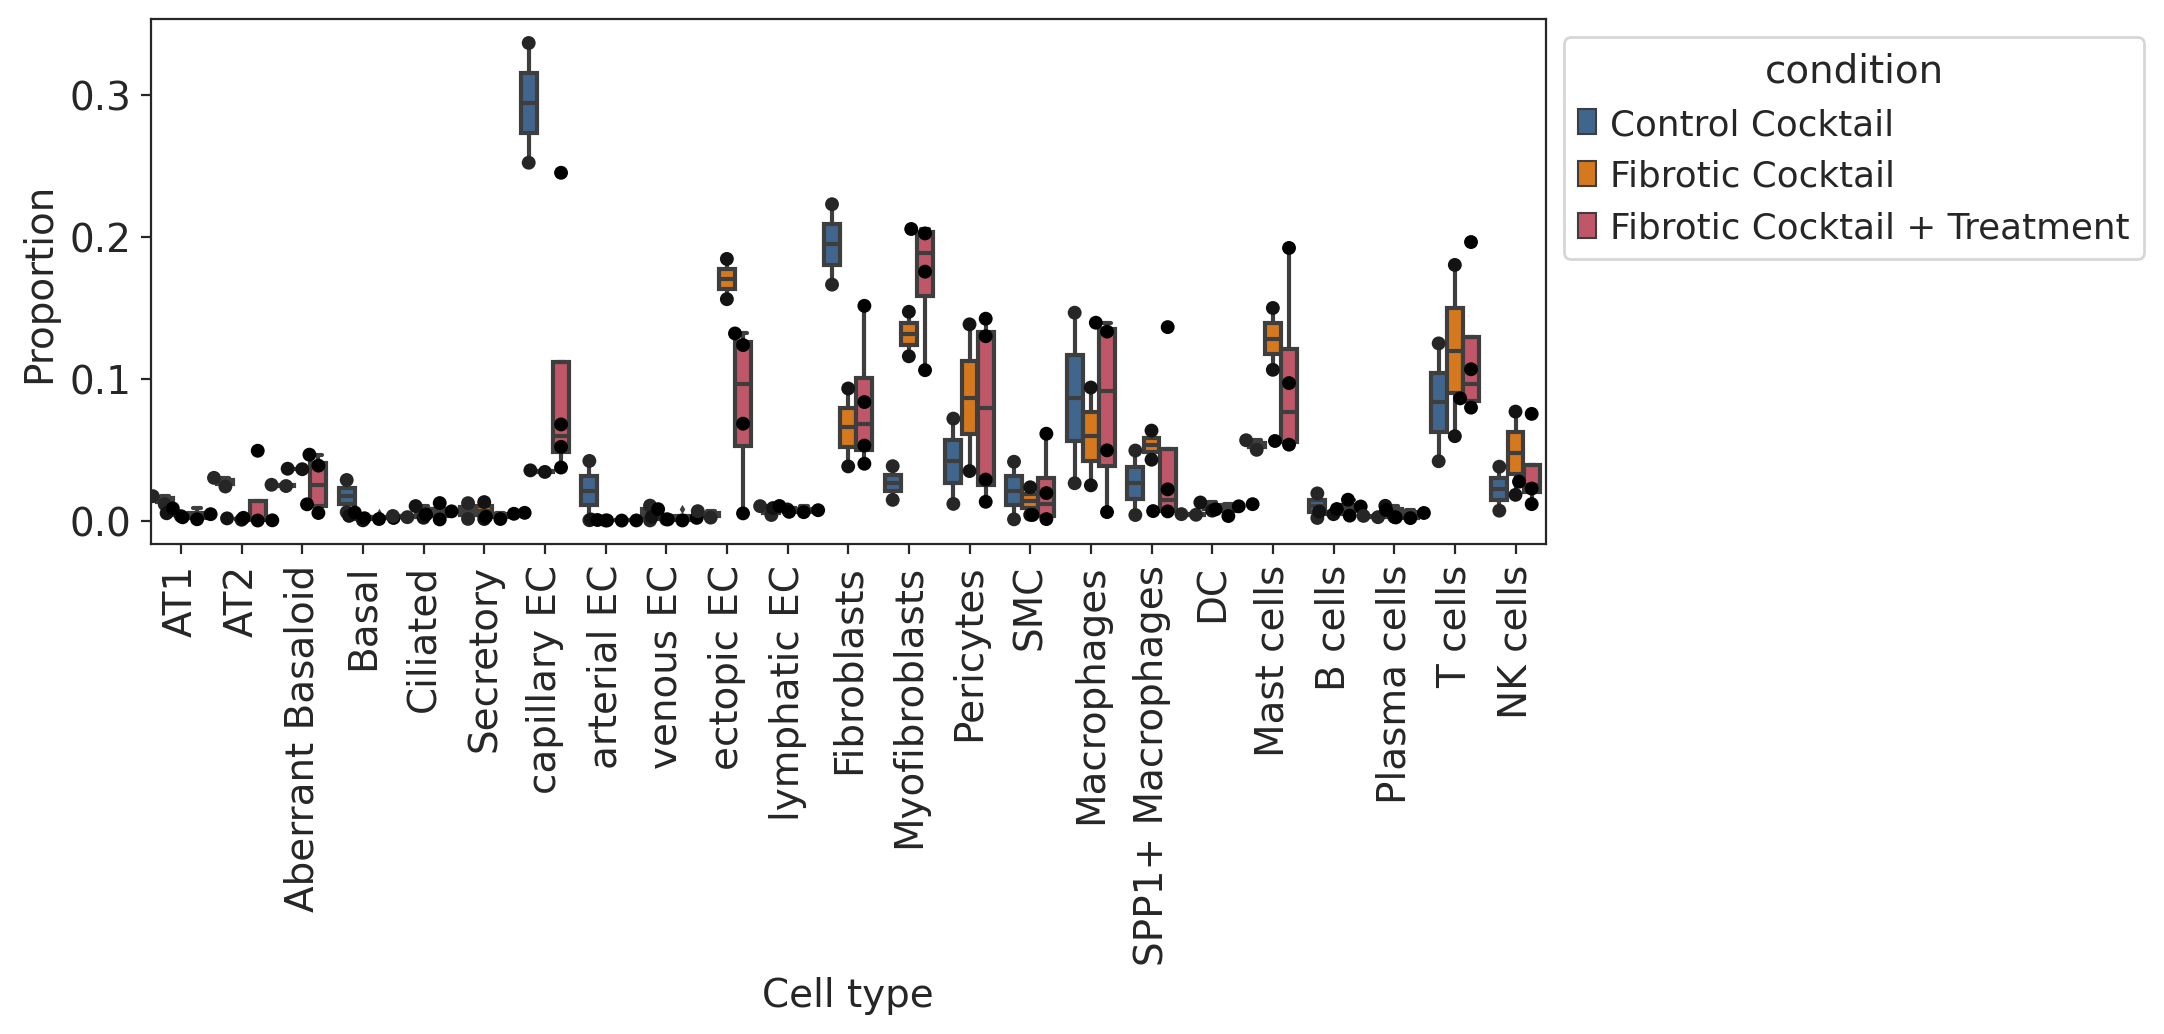

In [79]:
palette={
        "Control Cocktail": common_config.pt_blue,
        "Fibrotic Cocktail": common_config.pt_orange,
        "Fibrotic Cocktail + Treatment": common_config.pt_red
    }

sccoda_model.plot_boxplots(sccoda_data, modality_key="coda", feature_name="condition", add_dots=True, cmap=palette)
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.savefig("figures/compositional_boxplot_umap.png", bbox_inches="tight")

In [25]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="condition",
    reference_cell_type="automatic",
)

Automatic reference selection! Reference cell type set to lymphatic EC

Zero counts encountered in data! Added a pseudocount of 0.5.

In [27]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|██████████| 11000/11000 [02:02<00:00, 89.53it/s, 255 steps of size 2.09e-02. acc. prob=0.79]


In [28]:
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 8 samples, 23 cell types                                    │
│ Reference cell type                         │ lymphatic EC                                                      │
│ Formula                                     │ condition                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ AT1                    -0.596           115.264                                                                 │
│ AT2                    -0.774            96.469                                                                 │
│ Aberrant Basaloid       0.247           267.795                                                                 │
│ Basal                  -0.820            92.132                                                                 │
│ Ciliated               -0.771            96.759                                                                 │
│ Secretory              -0.799            94.087                                                                 │
│ capillary EC            2.075          1666.067                                                                 │
│ arterial EC            -1.439            49.611                                                                 │
│ venous EC              -1.163            65.380                                                                 │
│ ectopic EC              0.183           251.193                                                                 │
│ lymphatic EC           -0.451           133.249                                                                 │
│ Fibroblasts             1.618          1054.921                                                                 │
│ Myofibroblasts          0.941           536.047                                                                 │
│ Pericytes               0.722           430.618                                                                 │
│ SMC                    -0.421           137.307                                                                 │
│ Macrophages             0.861           494.833                                                                 │
│ SPP1+ Macrophages       0.165           246.712                                                                 │
│ DC                     -0.518           124.614                                                                 │
│ Mast cells              1.192           688.986                                                                 │
│ B cells                -0.519           124.489                                                                 │
│ Plasma cells           -0.785            95.414                                                                 │
│ T cells                 1.359           814.212                                                                 │
│ NK cells                0.262           271.842                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                             Final Parameter  Expected Sample  log2-fold change  │
│ Covariate                                Cell Type                                                              │
│ conditionT.Fibrotic Cocktail             AT1                     0.000           119.756            0.055       │
│                                          AT2                     0.000           100.229            0.055       │
│                                          Aberrant Basaloid       0.000           278.233            0.055       │
│                                          Basal                   0.000            95.723            0.055       │
│                                          Ciliated                0.000           100.530            0.055       │
│                                          Secretory               0.000            97.754            0.055       │
│                                          capillary EC           -1.305           469.181           -1.828       │
│                                          arterial EC             0.000            51.545            0.055       │
│                                          venous EC               0.000            67.929            0.055       │
│                                          ectopic EC              1.536          1213.019            2.272       │
│                                          lymphatic EC            0.000           138.443            0.055       │
│                                          Fibroblasts             0.000          1096.038            0.055       │
│                                          Myofibroblasts          0.000           556.940            0.055       │
│                                          Pericytes               0.000           447.402            0.055       │
│                                          SMC                     0.000           142.659            0.055       │
│                                          Macrophages             0.000           514.120            0.055       │
│                                          SPP1+ Macrophages       0.000           256.328            0.055       │
│                                          DC                      0.000           129.471            0.055       │
│                                          Mast cells              0.000           715.841            0.055       │
│                                          B cells                 0.000           129.342            0.055       │
│                                          Plasma cells            0.000            99.133            0.055       │
│                                          T cells                 0.000           845.948            0.055       │
│                                          NK cells                0.000           282.438            0.055       │
│ conditionT.Fibrotic Cocktail + Treatment AT1                     0.000           115.264            0.000       │
│                                          AT2                     0.000            96.469            0.000       │
│                                          Aberrant Basaloid       0.000           267.795            0.000       │
│                                          Basal                   0.000            92.132            0.000       │
│                                          Ciliated                0.000            96.759            0.000       │
│                                          Secretory               0.000            94.087            0.000       │
│                                          capillary EC 

In [29]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate                                   Cell Type        
condition[T.Fibrotic Cocktail]              AT1                  False
                                            AT2                  False
                                            Aberrant Basaloid    False
                                            Basal                False
                                            Ciliated             False
                                            Secretory            False
                                            capillary EC          True
                                            arterial EC          False
                                            venous EC            False
                                            ectopic EC            True
                                            lymphatic EC         False
                                            Fibroblasts          False
                                            Myofibroblasts       False
               

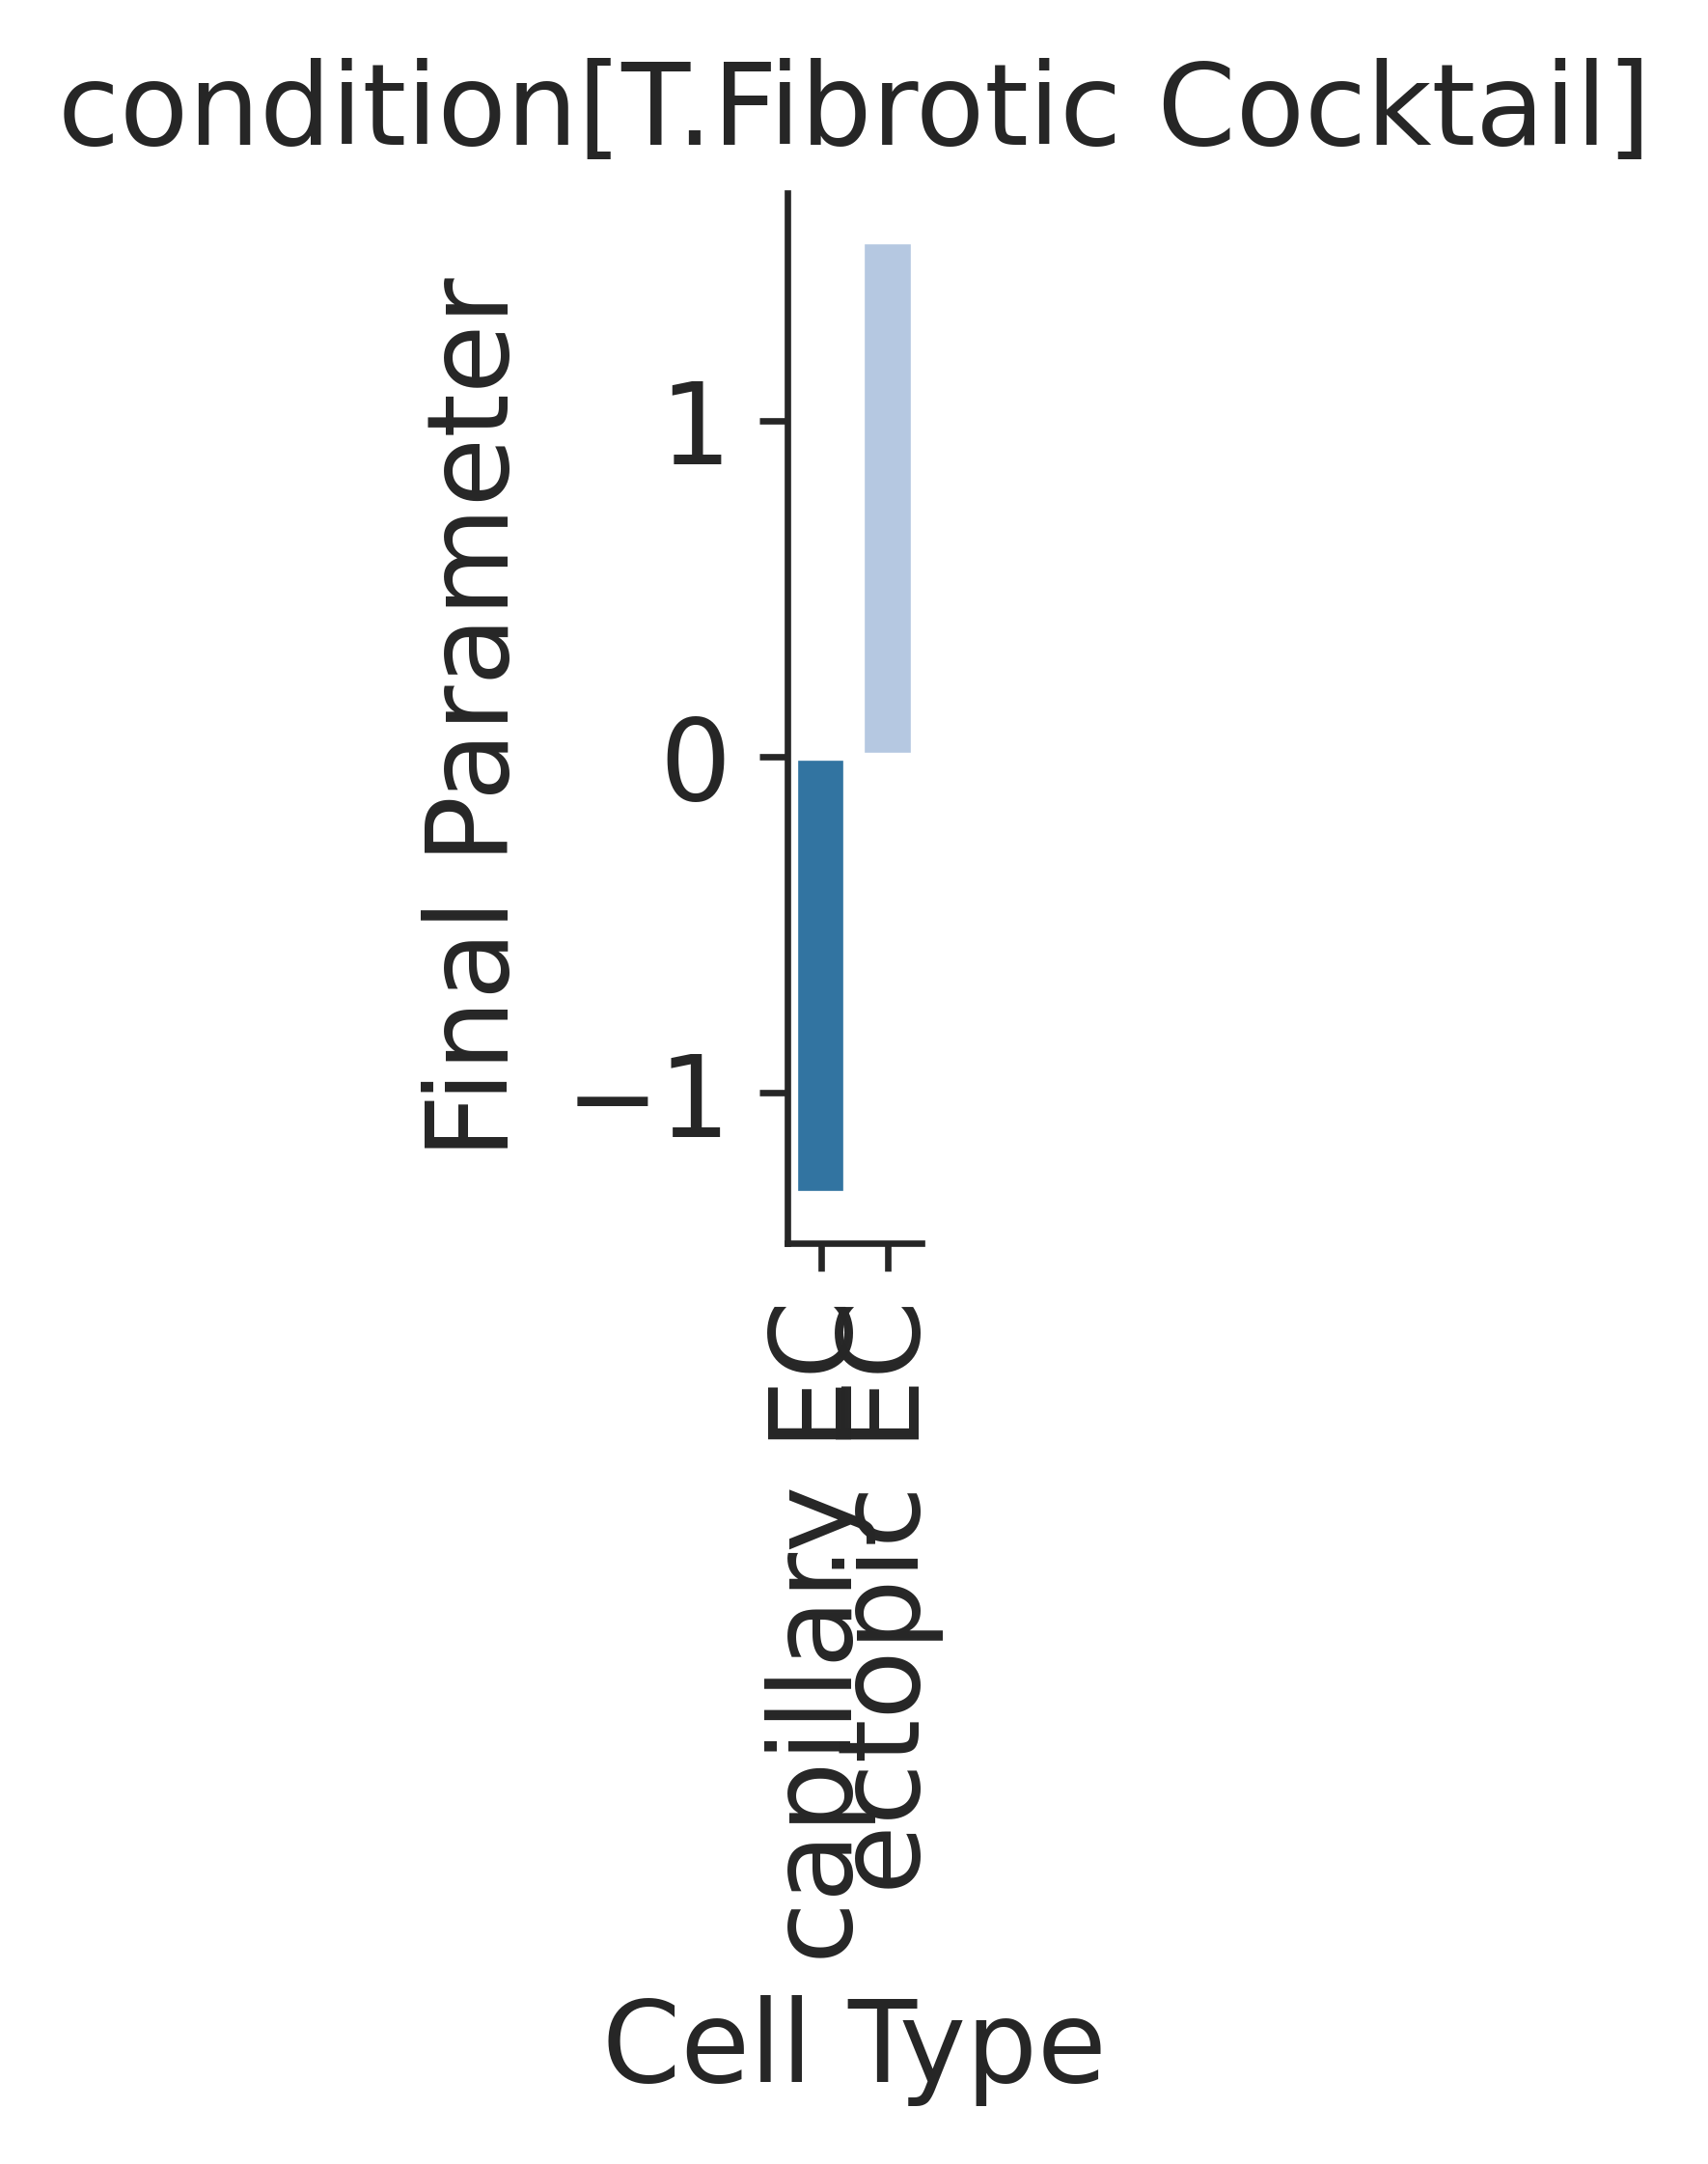

In [33]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda", parameter="Final Parameter")

In [36]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.2)
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 8 samples, 23 cell types                                    │
│ Reference cell type                         │ lymphatic EC                                                      │
│ Formula                                     │ condition                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ AT1                    -0.596           115.264                                                                 │
│ AT2                    -0.774            96.469                                                                 │
│ Aberrant Basaloid       0.247           267.795                                                                 │
│ Basal                  -0.820            92.132                                                                 │
│ Ciliated               -0.771            96.759                                                                 │
│ Secretory              -0.799            94.087                                                                 │
│ capillary EC            2.075          1666.067                                                                 │
│ arterial EC            -1.439            49.611                                                                 │
│ venous EC              -1.163            65.380                                                                 │
│ ectopic EC              0.183           251.193                                                                 │
│ lymphatic EC           -0.451           133.249                                                                 │
│ Fibroblasts             1.618          1054.921                                                                 │
│ Myofibroblasts          0.941           536.047                                                                 │
│ Pericytes               0.722           430.618                                                                 │
│ SMC                    -0.421           137.307                                                                 │
│ Macrophages             0.861           494.833                                                                 │
│ SPP1+ Macrophages       0.165           246.712                                                                 │
│ DC                     -0.518           124.614                                                                 │
│ Mast cells              1.192           688.986                                                                 │
│ B cells                -0.519           124.489                                                                 │
│ Plasma cells           -0.785            95.414                                                                 │
│ T cells                 1.359           814.212                                                                 │
│ NK cells                0.262           271.842                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                             Final Parameter  Expected Sample  log2-fold change  │
│ Covariate                                Cell Type                                                              │
│ conditionT.Fibrotic Cocktail             AT1                     0.000           118.621            0.041       │
│                                          AT2                     0.000            99.279            0.041       │
│                                          Aberrant Basaloid       0.000           275.594            0.041       │
│                                          Basal                   0.000            94.815            0.041       │
│                                          Ciliated                0.000            99.577            0.041       │
│                                          Secretory               0.000            96.827            0.041       │
│                                          capillary EC           -1.305           464.732           -1.842       │
│                                          arterial EC             0.000            51.056            0.041       │
│                                          venous EC               0.000            67.285            0.041       │
│                                          ectopic EC              1.536          1201.518            2.258       │
│                                          lymphatic EC            0.000           137.130            0.041       │
│                                          Fibroblasts            -0.657           562.740           -0.907       │
│                                          Myofibroblasts          0.735          1149.926            1.101       │
│                                          Pericytes               0.000           443.160            0.041       │
│                                          SMC                     0.000           141.306            0.041       │
│                                          Macrophages             0.000           509.246            0.041       │
│                                          SPP1+ Macrophages       0.000           253.897            0.041       │
│                                          DC                      0.000           128.243            0.041       │
│                                          Mast cells              0.000           709.053            0.041       │
│                                          B cells                 0.000           128.115            0.041       │
│                                          Plasma cells            0.000            98.193            0.041       │
│                                          T cells                 0.000           837.927            0.041       │
│                                          NK cells                0.000           279.760            0.041       │
│ conditionT.Fibrotic Cocktail + Treatment AT1                     0.000           127.967            0.151       │
│                                          AT2                     0.000           107.101            0.151       │
│                                          Aberrant Basaloid       0.000           297.309            0.151       │
│                                          Basal                   0.000           102.286            0.151       │
│                                          Ciliated                0.000           107.423            0.151       │
│                                          Secretory               0.000           104.457            0.151       │
│                                          capillary EC 

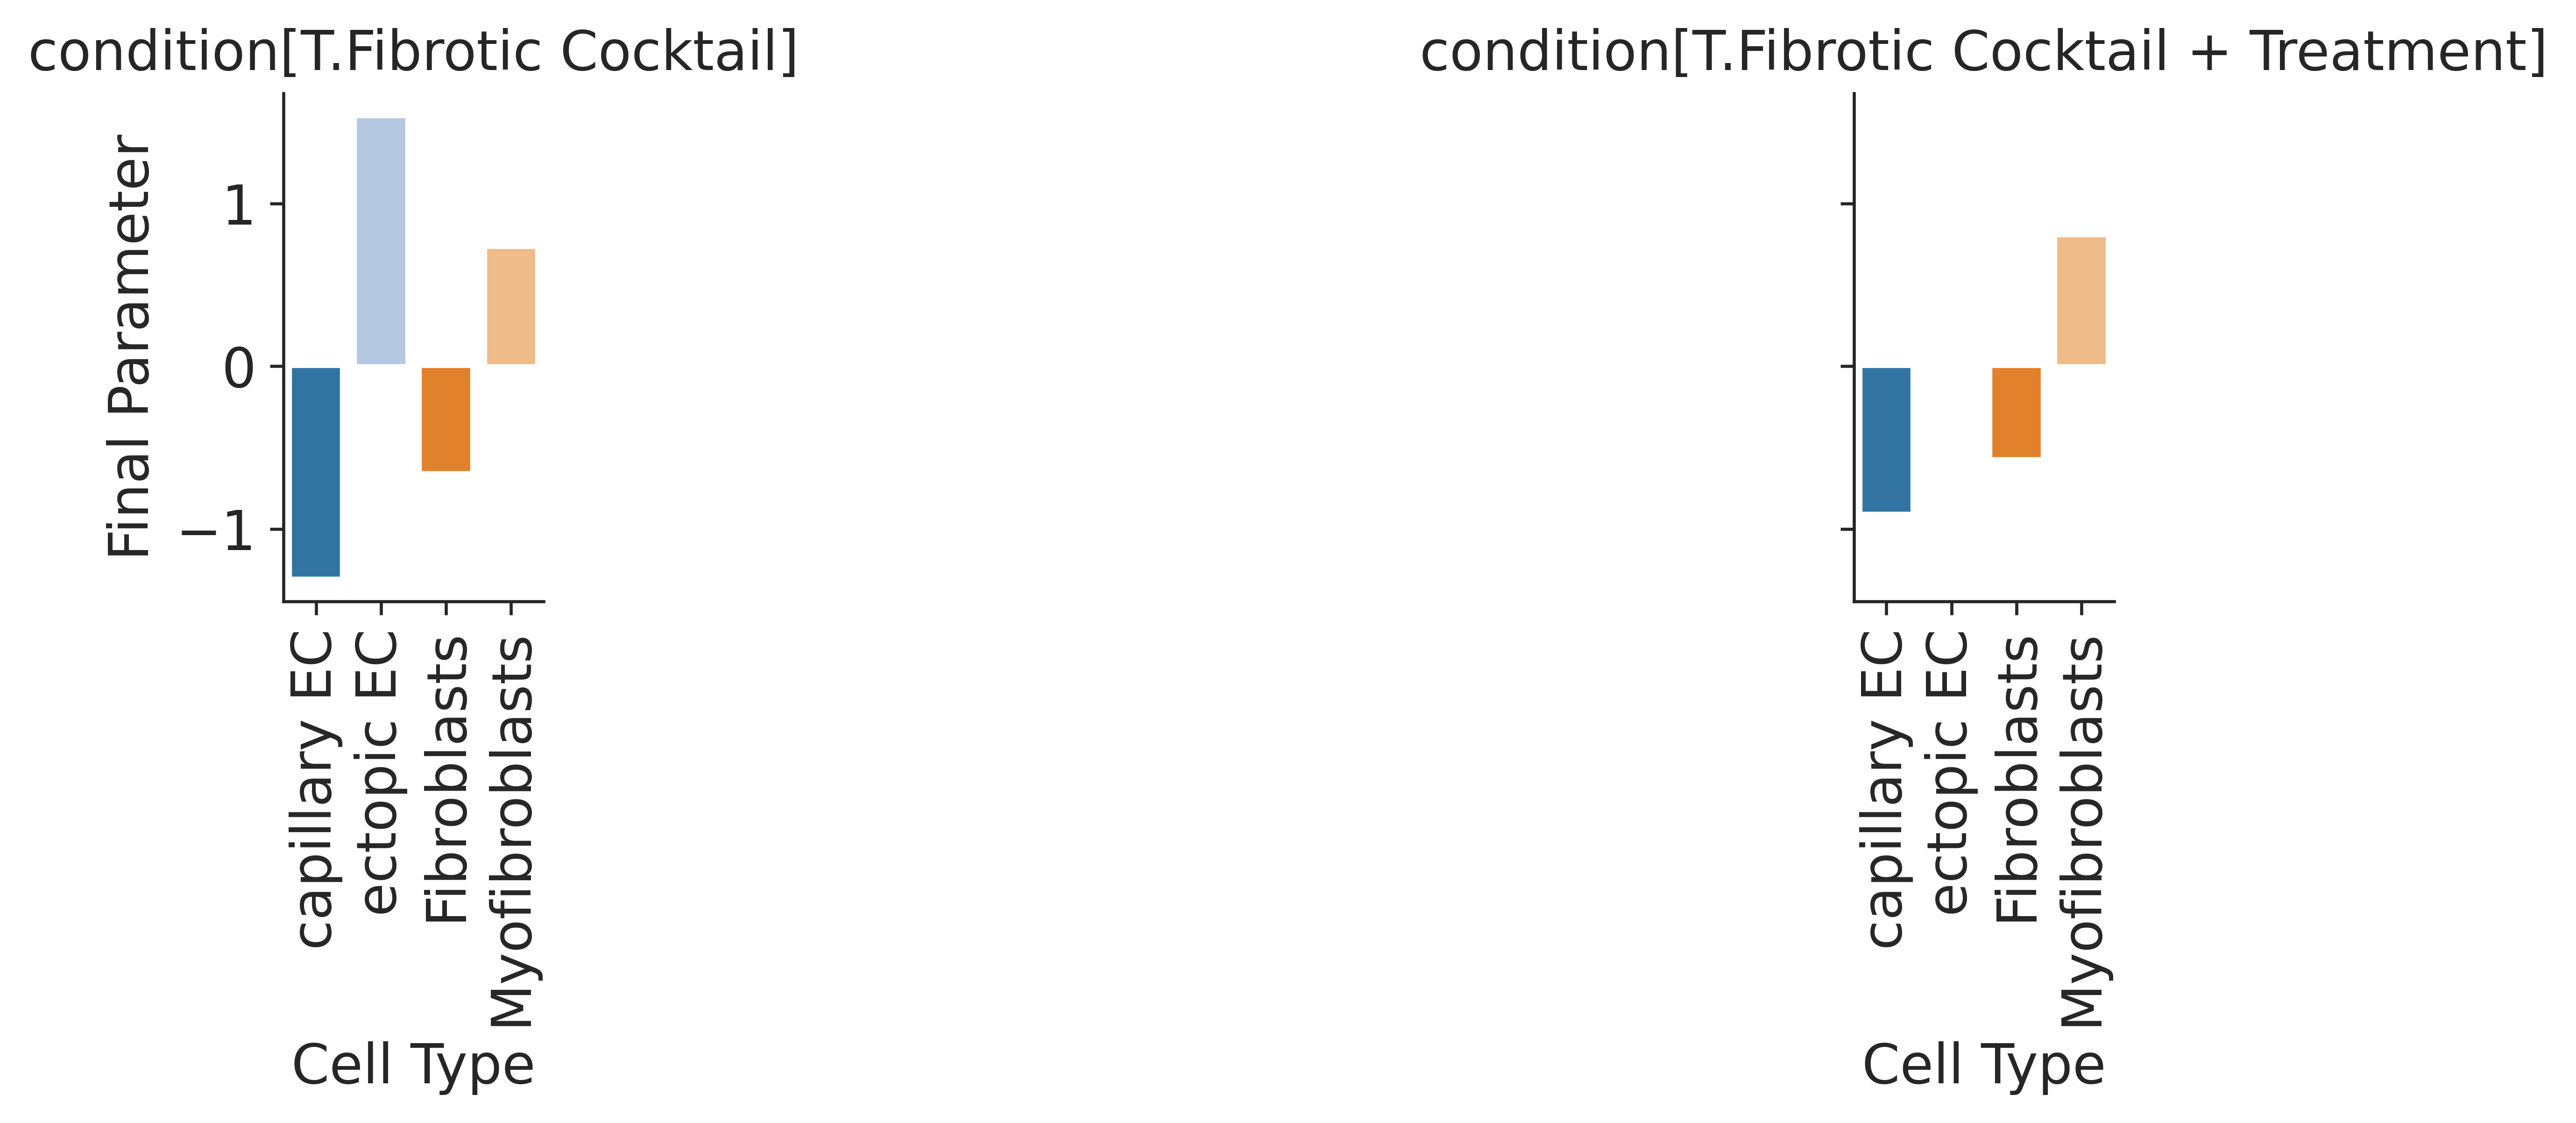

In [80]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda", parameter="Final Parameter")
plt.savefig("figures/effects_barplot_final_parameter.png", bbox_inches="tight")

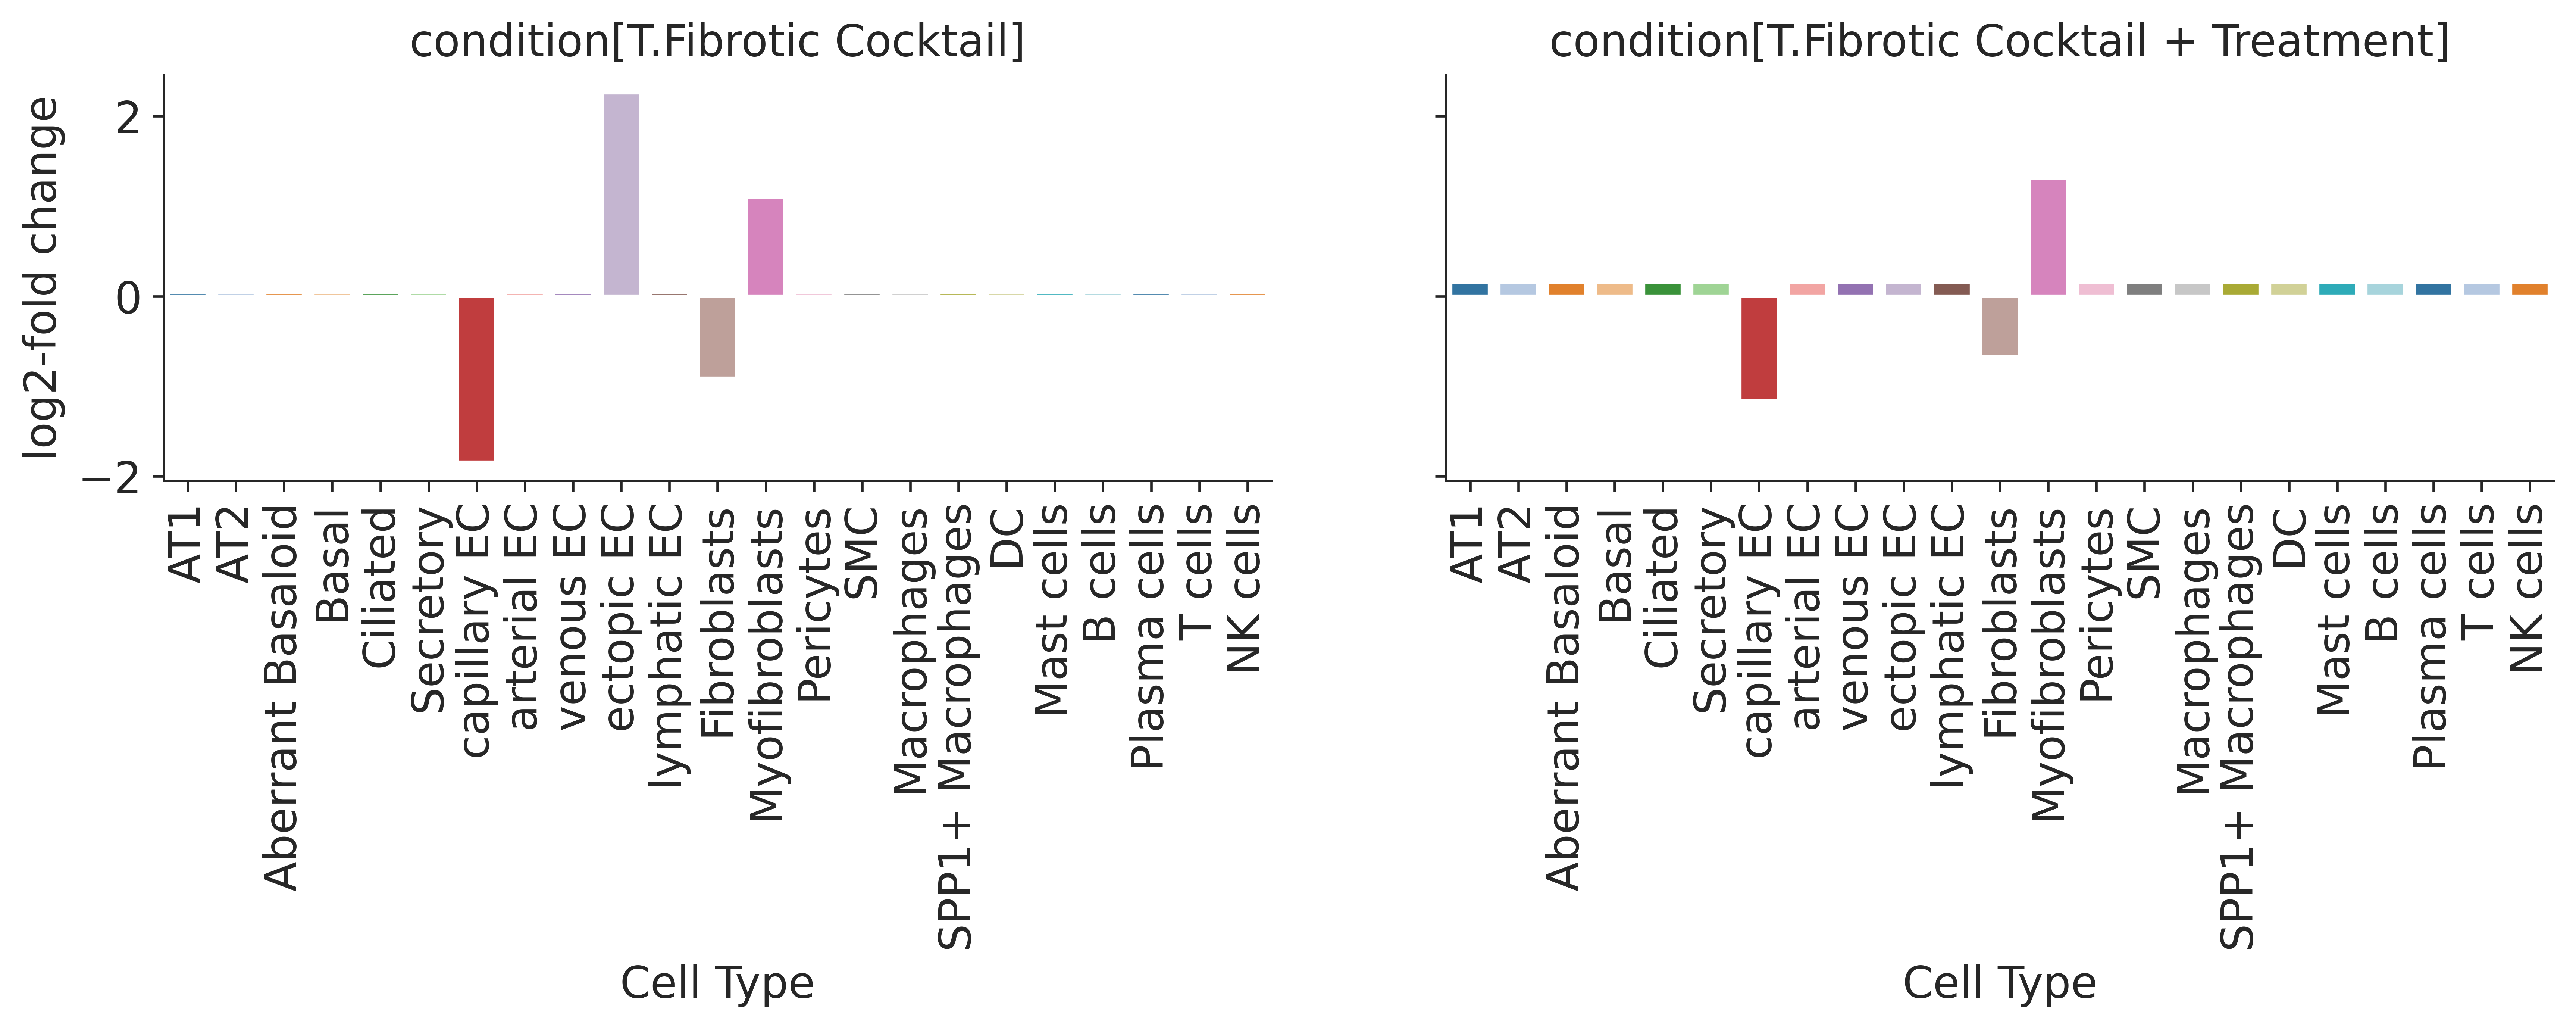

In [81]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda", parameter="log2-fold change")
plt.savefig("figures/final_parameter_boxplot_log2fc.png", bbox_inches="tight")

## MILO

In [41]:
milo = pt.tl.Milo()
milo_data = milo.load(adata)

In [44]:
milo.make_nhoods(milo_data["rna"], prop=0.1)

In [48]:
print(f"Number of neighborhoods: {milo_data['rna'].obsm['nhoods'].shape[1]}")

Number of neighborhoods: 4408


Text(0, 0.5, '# nhoods')

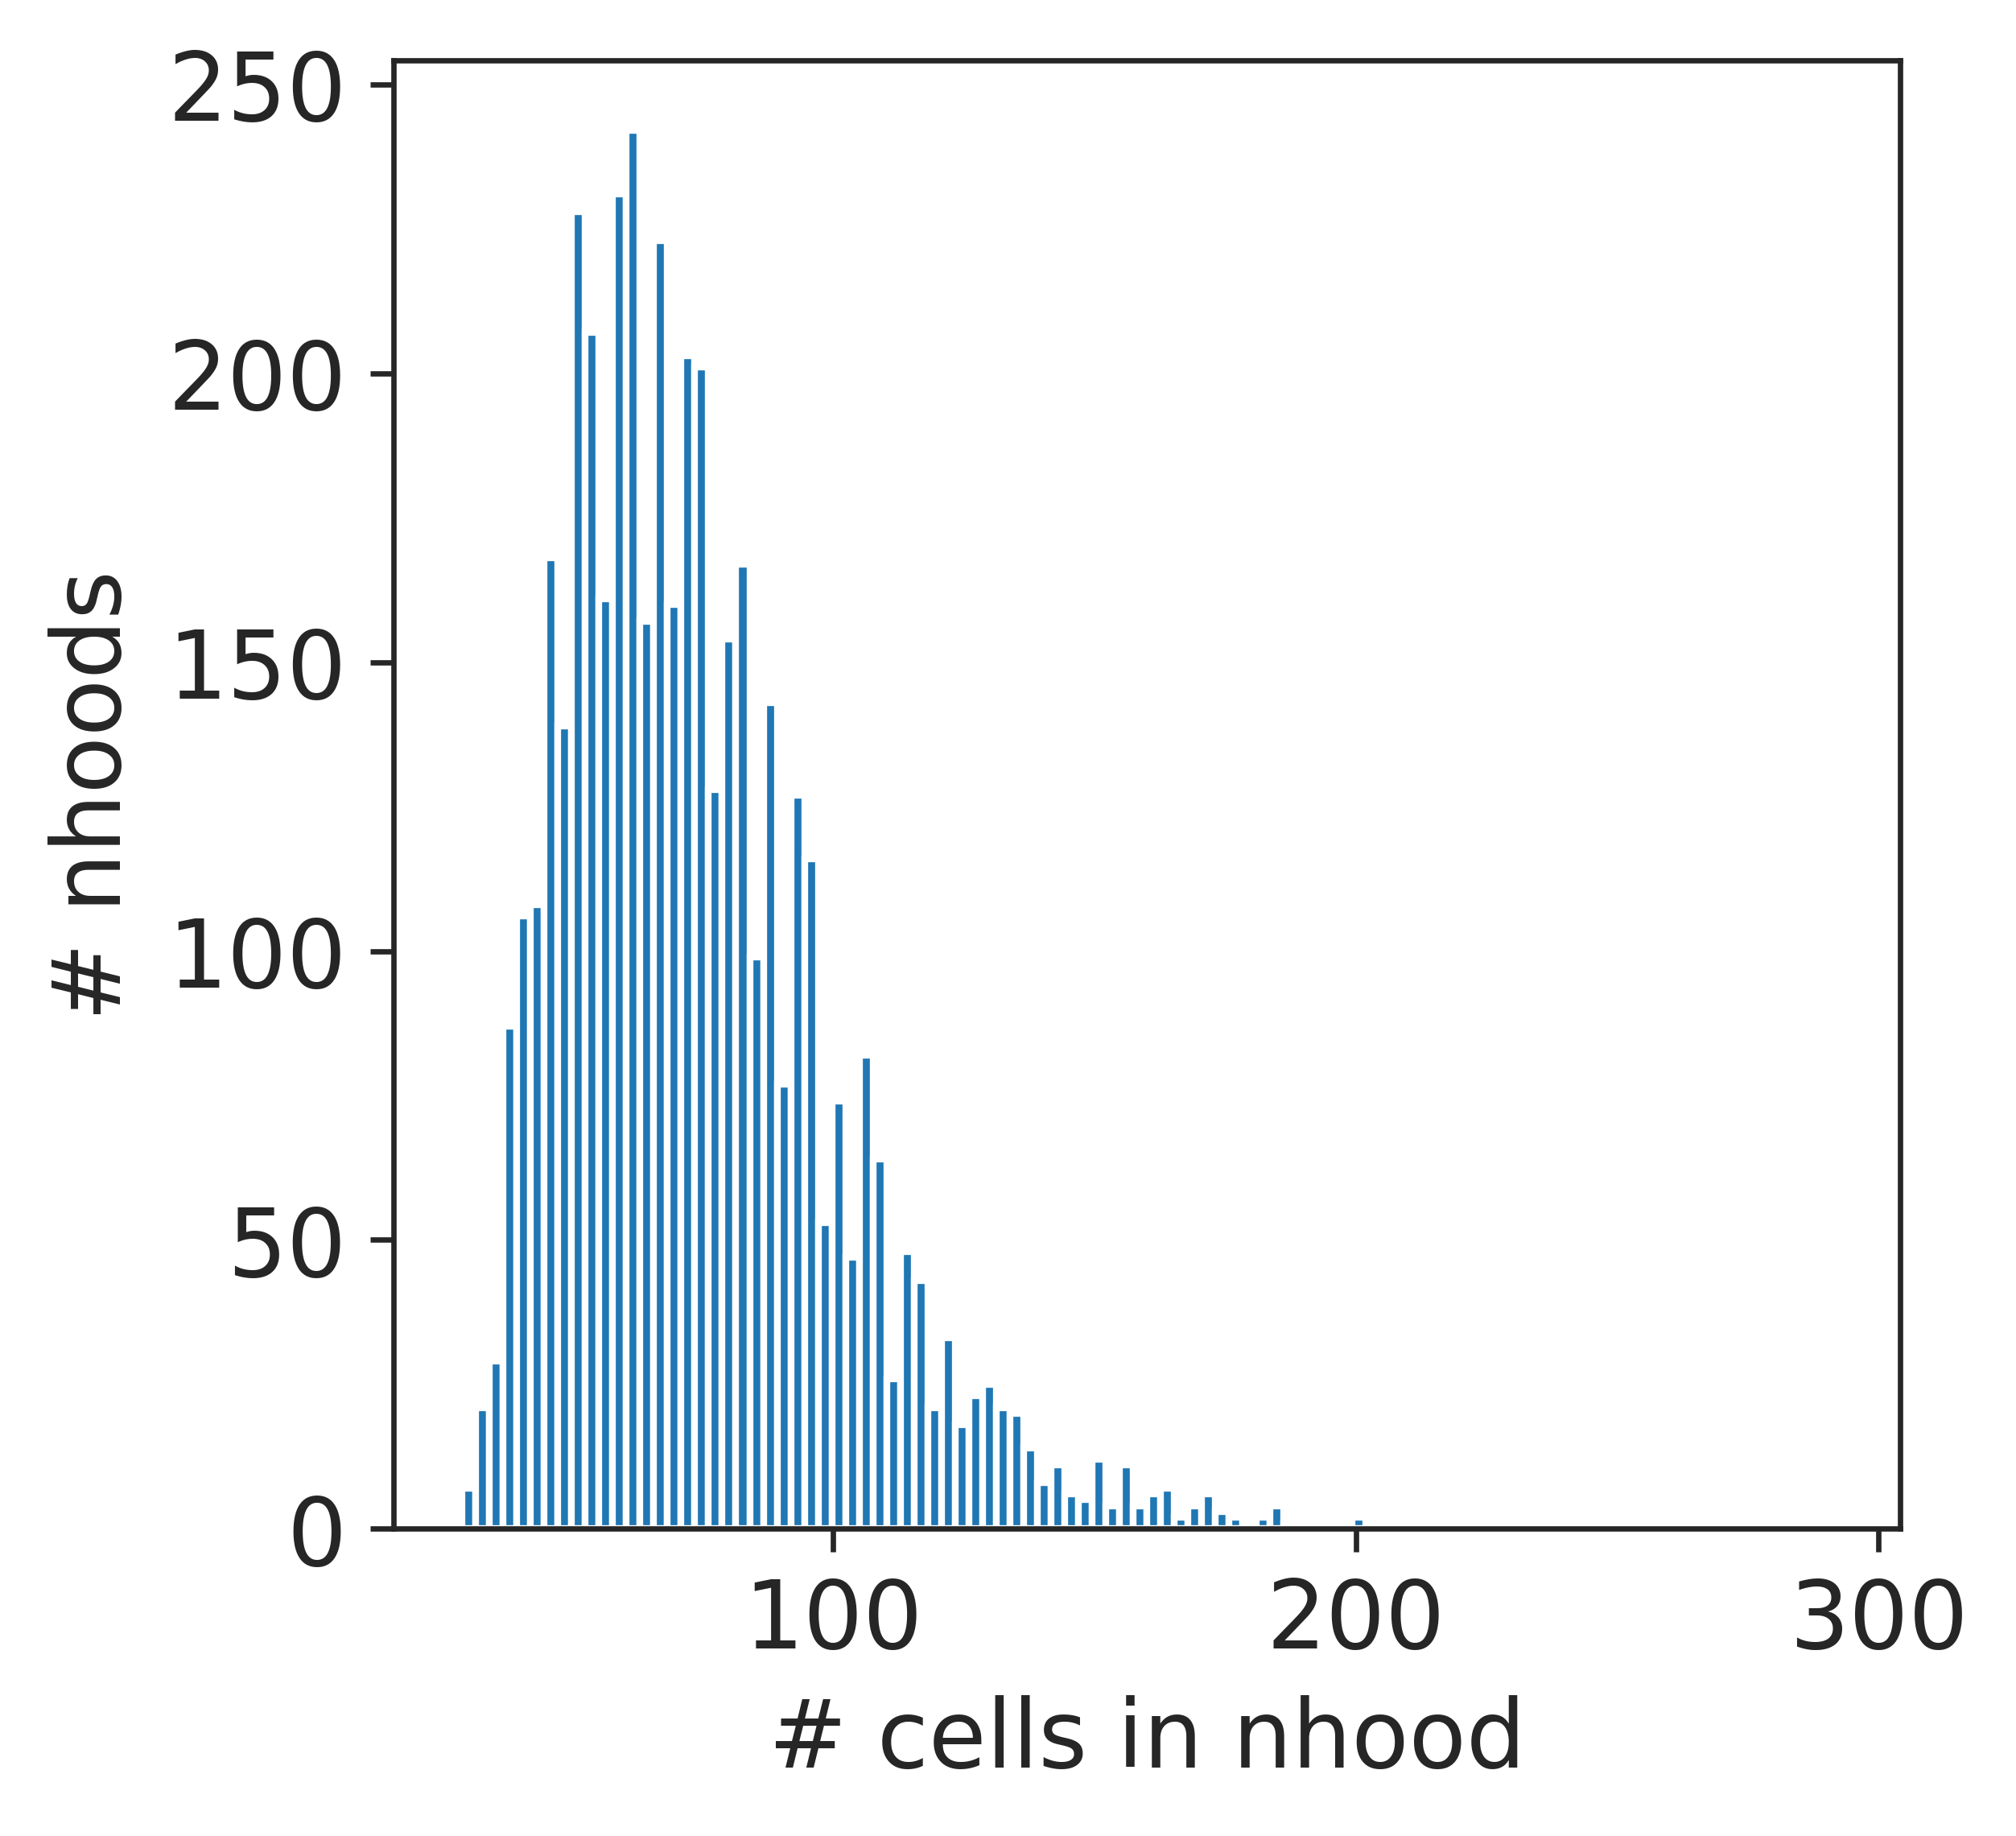

In [57]:
nhood_size = np.array(milo_data["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)
plt.xlabel("# cells in nhood")
plt.ylabel("# nhoods")

In [58]:
mdata = milo.count_nhoods(milo_data, sample_col="treatment")

In [71]:
mdata["rna"].obs["condition"]

muc31175_AAACCCAAGATCCCGC    Fibrotic Cocktail
muc31175_AAACCCAAGTAAAGCT    Fibrotic Cocktail
muc31175_AAACCCACAAGTTGGG    Fibrotic Cocktail
muc31175_AAACCCACACCAAAGG    Fibrotic Cocktail
muc31175_AAACCCACACCTCGTT    Fibrotic Cocktail
                                   ...        
muc24279_TTTGATCGTTAGTCGT    Fibrotic Cocktail
muc24279_TTTGATCGTTCCCACT    Fibrotic Cocktail
muc24279_TTTGGAGCACGATAGG    Fibrotic Cocktail
muc24279_TTTGTTGCAAGACAAT    Fibrotic Cocktail
muc24279_TTTGTTGTCGATACGT    Fibrotic Cocktail
Name: condition, Length: 63581, dtype: category
Categories (3, object): ['Control Cocktail', 'Fibrotic Cocktail', 'Fibrotic Cocktail + Treatment']

In [70]:
milo.da_nhoods(mdata, design="~condition")

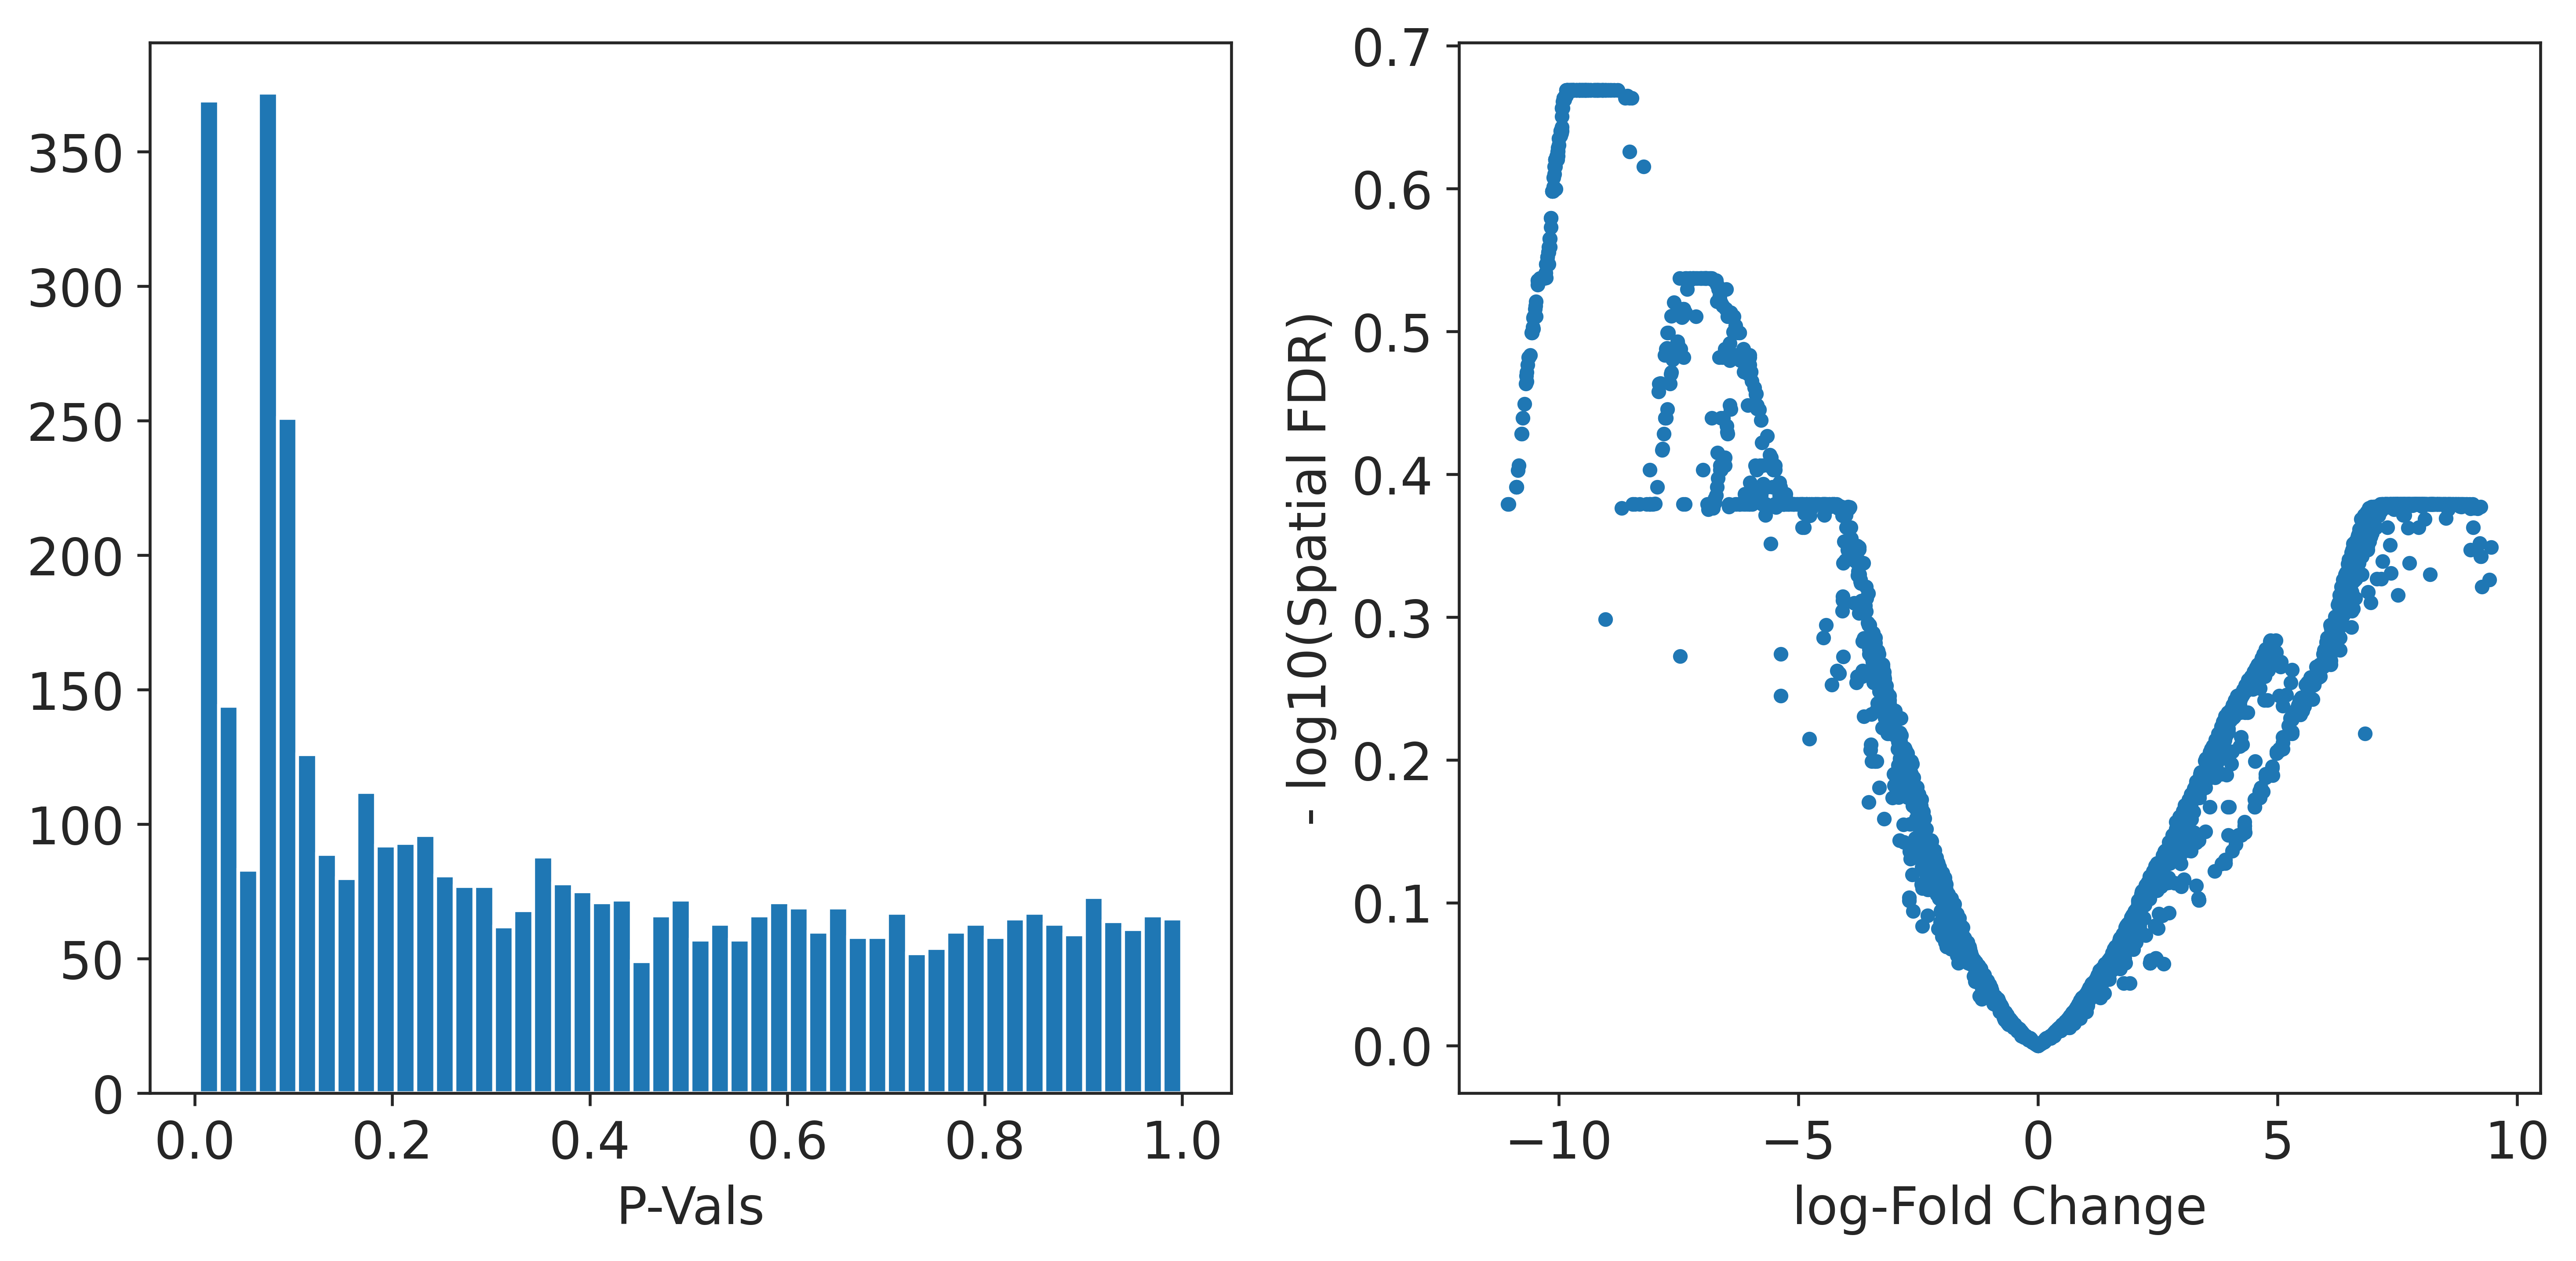

In [74]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.subplot(1, 2, 1)
plt.hist(mdata["milo"].var.PValue, bins=50)
plt.xlabel("P-Vals")
plt.subplot(1, 2, 2)
plt.plot(mdata["milo"].var.logFC, -np.log10(mdata["milo"].var.SpatialFDR), ".")
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()

In [60]:
milo.build_nhood_graph(mdata)

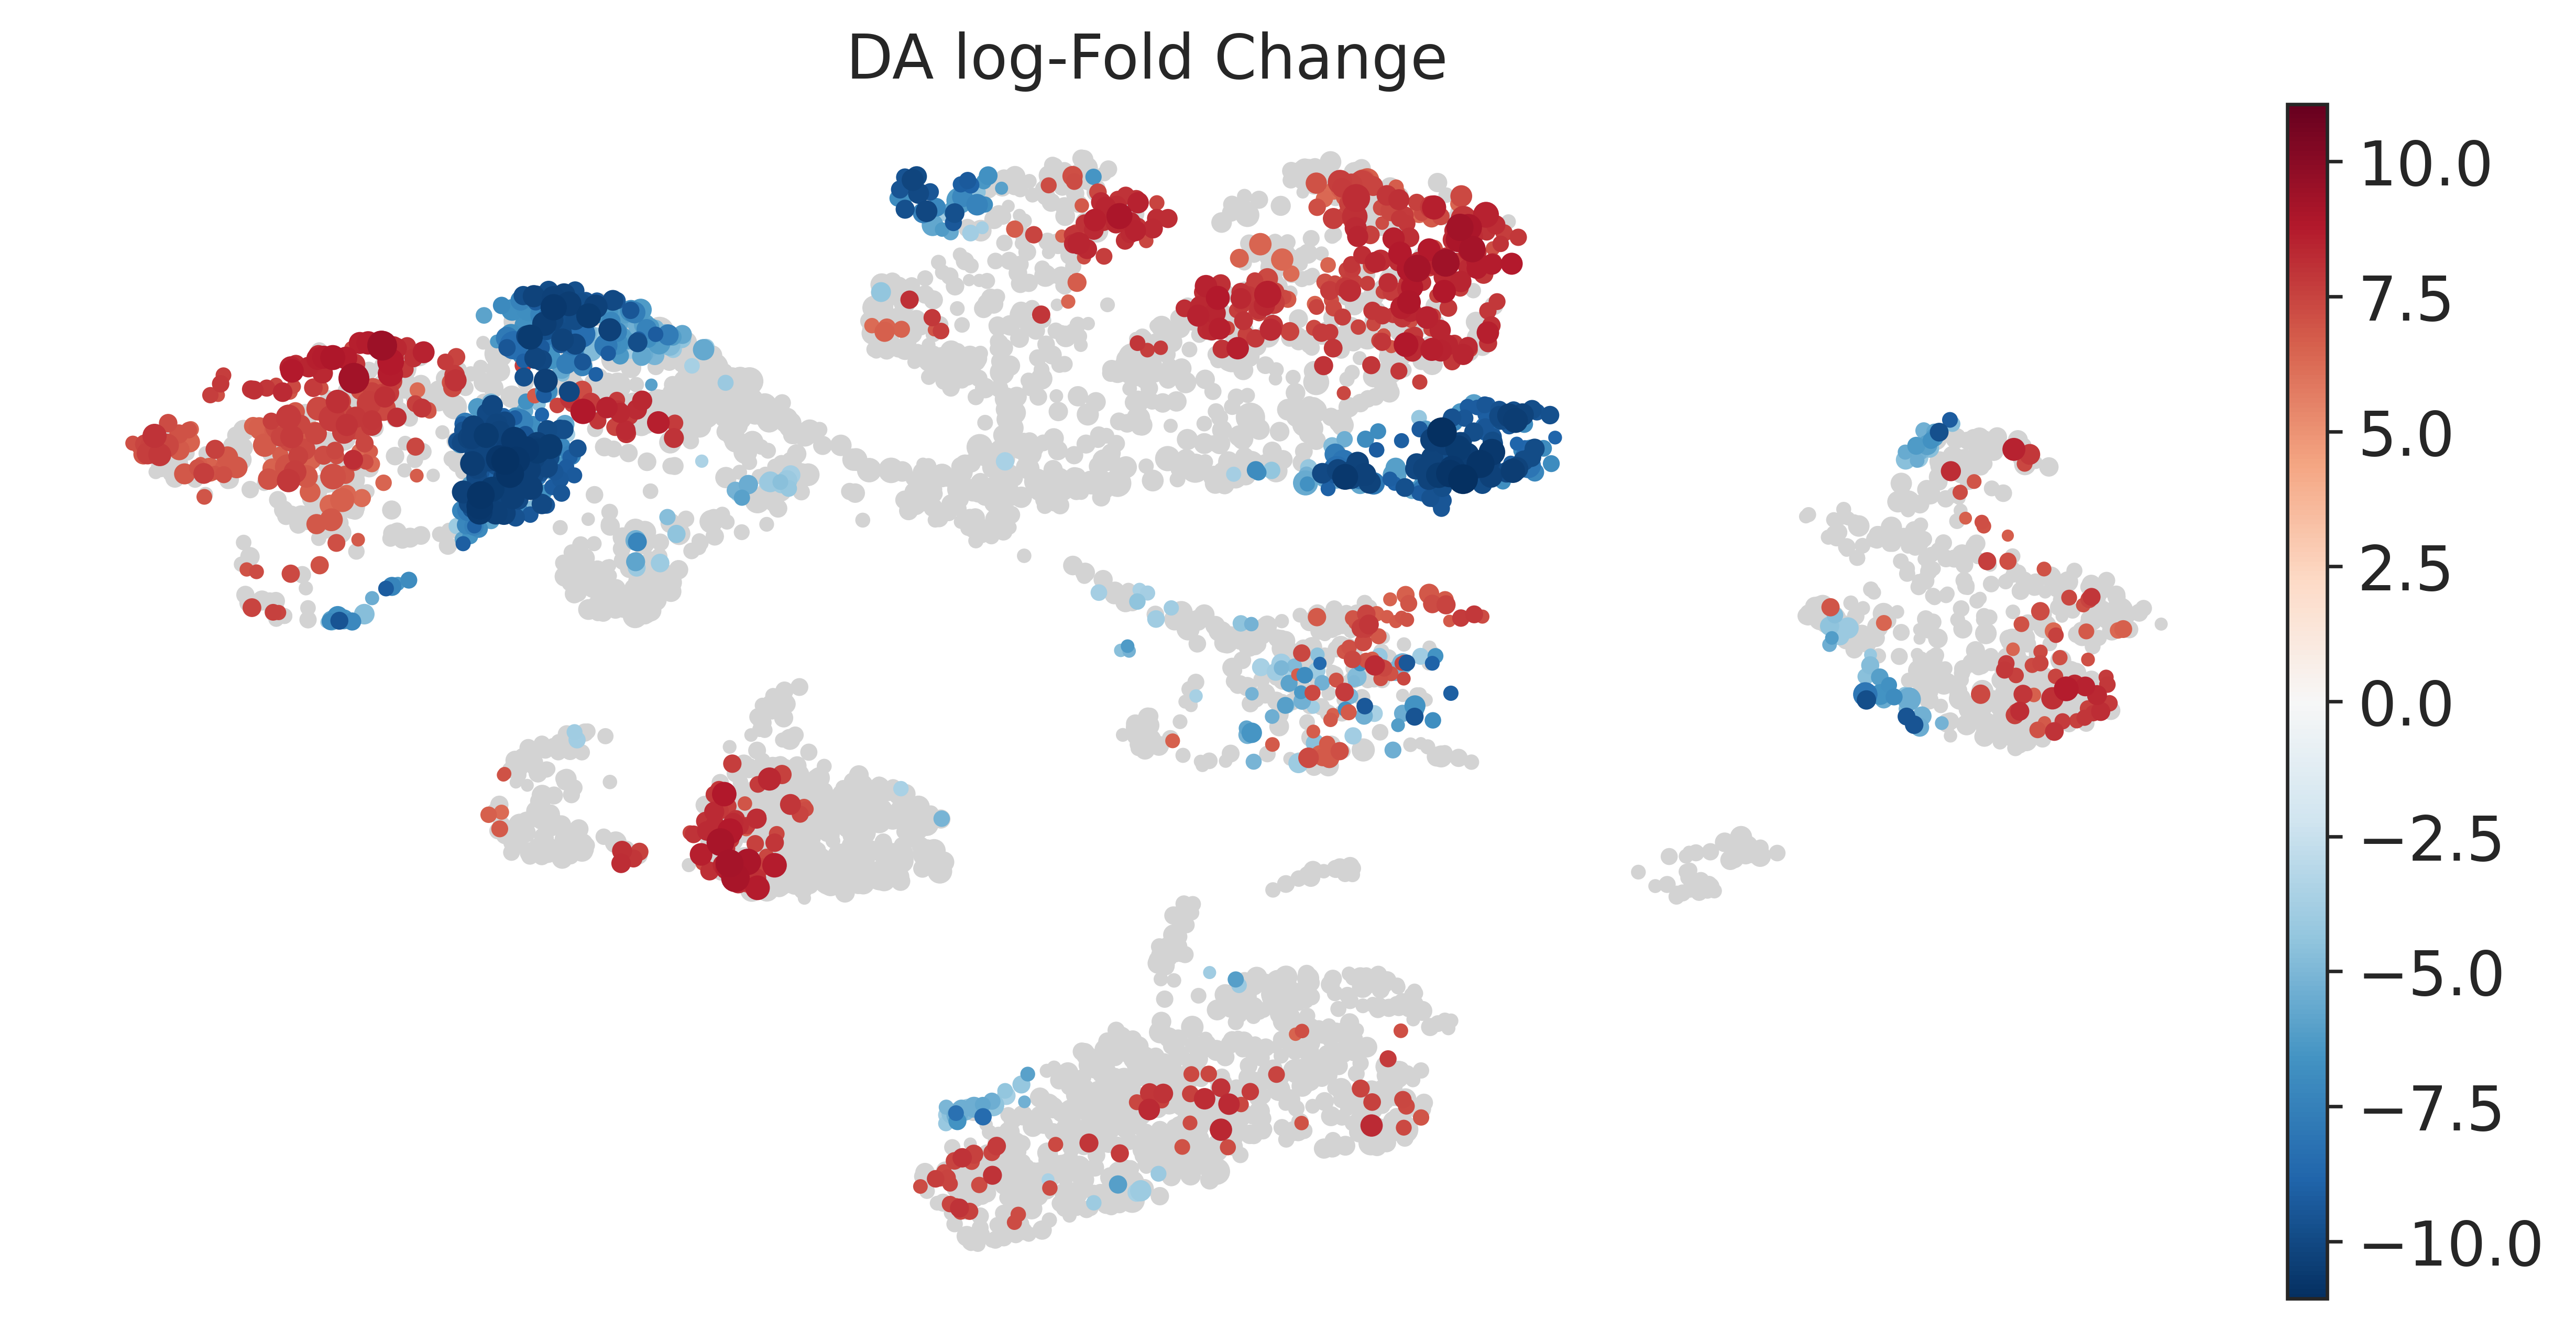

<Figure size 3000x1500 with 0 Axes>

: 

In [82]:
milo.plot_nhood_graph(
    mdata,
    alpha=0.5,
    min_size=1,
)
plt.savefig("figures/milo_da_umap.png", bbox_inches="tight")